<a href="https://colab.research.google.com/github/M-torki/ECG-Classification/blob/main/sprint4_xResNet_Inception_icbeb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook is based on the paper: 

**[Deep Learning for ECG Analysis: Benchmarks and Insights from PTB-XL](https://ieeexplore.ieee.org/document/9190034)**

The related codes are available on this [Github](https://github.com/helme/ecg_ptbxl_benchmarking/) 

link to [PTB XL](https://physionet.org/content/ptb-xl/1.0.1/) database, 
link to [ICBEB2018](http://2018.icbeb.org/Challenge.html) database

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
cd /gdrive/MyDrive/

/gdrive/MyDrive


In [ ]:
!pip install wfdb

     |████████████████████████████████| 137 kB 5.2 MB/s 


In [ ]:
# !git clone https://github.com/helme/ecg_ptbxl_benchmarking/

In [ ]:
#@title Download ICBEB
!mkdir -p ICBEB
!cd ICBEB
!wget http://2018.icbeb.org/file/REFERENCE.csv
!wget http://hhbucket.oss-cn-hongkong.aliyuncs.com/TrainingSet1.zip
!wget http://hhbucket.oss-cn-hongkong.aliyuncs.com/TrainingSet2.zip
!wget http://hhbucket.oss-cn-hongkong.aliyuncs.com/TrainingSet3.zip
!unzip TrainingSet1.zip
!unzip TrainingSet2.zip
!unzip TrainingSet3.zip

In [ ]:
#@title stratisfy
import pandas as pd 
import numpy as np 
from tqdm import tqdm

def stratisfy_df(df, new_col_name, n_folds=10, nr_clean_folds=0):
    # compute qualities as described in PTB-XL report
    quals = []
    for i, row in df.iterrows():
        q = 0
        if 'validated_by_human' in df.columns:
            if row.validated_by_human == True:
                q = 1
        quals.append(q)
    df['quality'] = quals

    # create stratisfied folds according to patients
    pat_ids = np.array(sorted(list(set(df.patient_id.values))))
    plabels = []
    pquals = []
    ecgs_per_patient = []

    for pid in tqdm(pat_ids):
        sel = df[df.patient_id == pid]
        l = np.concatenate([list(d.keys())for d in sel.scp_codes.values])
        if sel.sex.values[0] == 0:
            gender='male'
        else:
            gender='female'
        l = np.concatenate((l, [gender]*len(sel)))
        for age in sel.age.values:
            if age < 20:
                l = np.concatenate((l,['<20']))
            elif age >= 20 and age < 40:
                l = np.concatenate((l,['20-40']))
            elif age >= 40 and age < 60:
                l = np.concatenate((l,['40-60']))
            elif age >= 60 and age < 80:
                l = np.concatenate((l,['60-80']))
            elif age >= 80:
                l = np.concatenate((l,['>=80']))
        plabels.append(l)
        ecgs_per_patient.append(len(sel))
        pquals.append(sel.quality.min())
    classes = sorted(list(set([item for sublist in plabels for item in sublist])))

    stratified_data_ids, stratified_data = stratify(plabels, classes, [1/n_folds]*n_folds, pquals, ecgs_per_patient, nr_clean_folds)

    df[new_col_name] = np.zeros(len(df)).astype(int)
    for fold_i, fold_ids in tqdm(enumerate(stratified_data_ids)):
        ipat_ids = [pat_ids[pid] for pid in fold_ids]
        df[new_col_name][df.patient_id.isin(ipat_ids)] = fold_i + 1

    return df

def stratify(data, classes, ratios, qualities, ecgs_per_patient, nr_clean_folds=1):
    """Stratifying procedure. Modified from https://vict0rs.ch/2018/05/24/sample-multilabel-dataset/ (based on Sechidis 2011)
    data is a list of lists: a list of labels, for each sample.
        Each sample's labels should be ints, if they are one-hot encoded, use one_hot=True
    
    classes is the list of classes each label can take
    ratios is a list, summing to 1, of how the dataset should be split
    qualities: quality per entry (only >0 can be assigned to clean folds; 4 will always be assigned to final fold)
    ecgs_per_patient: list with number of ecgs per sample
    nr_clean_folds: the last nr_clean_folds can only take clean entries
    """
    np.random.seed(0) # fix the random seed

    # data is now always a list of lists; len(data) is the number of patients; data[i] is the list of all labels for patient i (possibly multiple identical entries)

    #size is the number of ecgs
    size = np.sum(ecgs_per_patient)

    # Organize data per label: for each label l, per_label_data[l] contains the list of patients
    # in data which have this label (potentially multiple identical entries)
    per_label_data = {c: [] for c in classes}
    for i, d in enumerate(data):
        for l in d:
            per_label_data[l].append(i)

    # In order not to compute lengths each time, they are tracked here.
    subset_sizes = [r * size for r in ratios] #list of subset_sizes in terms of ecgs
    per_label_subset_sizes = { c: [r * len(per_label_data[c]) for r in ratios] for c in classes } #dictionary with label: list of subset sizes in terms of patients

    # For each subset we want, the set of sample-ids which should end up in it
    stratified_data_ids = [set() for _ in range(len(ratios))] #initialize empty

    # For each sample in the data set
    print("Assigning patients to folds...")
    size_prev=size+1 #just for output
    while size > 0:
        if(int(size_prev/1000) > int(size/1000)):
            print("Remaining patients/ecgs to distribute:",size,"non-empty labels:", np.sum([1 for l, label_data in per_label_data.items() if len(label_data)>0]))
        size_prev=size
        # Compute |Di| 
        lengths = {
            l: len(label_data)
            for l, label_data in per_label_data.items()
        } #dictionary label: number of ecgs with this label that have not been assigned to a fold yet
        try:
            # Find label of smallest |Di|
            label = min({k: v for k, v in lengths.items() if v > 0}, key=lengths.get)
        except ValueError:
            # If the dictionary in `min` is empty we get a Value Error. 
            # This can happen if there are unlabeled samples.
            # In this case, `size` would be > 0 but only samples without label would remain.
            # "No label" could be a class in itself: it's up to you to format your data accordingly.
            break
        # For each patient with label `label` get patient and corresponding counts
        unique_samples, unique_counts = np.unique(per_label_data[label],return_counts=True)
        idxs_sorted = np.argsort(unique_counts, kind='stable')[::-1]
        unique_samples = unique_samples[idxs_sorted] # this is a list of all patient ids with this label sort by size descending
        unique_counts =  unique_counts[idxs_sorted] # these are the corresponding counts
        
        # loop through all patient ids with this label
        for current_id, current_count in zip(unique_samples,unique_counts):
            
            subset_sizes_for_label = per_label_subset_sizes[label] #current subset sizes for the chosen label

            #if quality is bad remove clean folds (i.e. sample cannot be assigned to clean folds)
            if(qualities[current_id] < 1):
                subset_sizes_for_label = subset_sizes_for_label[:len(ratios)-nr_clean_folds]

            # Find argmax clj i.e. subset in greatest need of the current label
            largest_subsets = np.argwhere(subset_sizes_for_label == np.amax(subset_sizes_for_label)).flatten()
            
            # if there is a single best choice: assign it
            if len(largest_subsets) == 1:
                subset = largest_subsets[0]
            # If there is more than one such subset, find the one in greatest need of any label
            else:
                largest_subsets2 = np.argwhere(np.array(subset_sizes)[largest_subsets] == np.amax(np.array(subset_sizes)[largest_subsets])).flatten()
                subset = largest_subsets[np.random.choice(largest_subsets2)]

            # Store the sample's id in the selected subset
            stratified_data_ids[subset].add(current_id)

            # There is current_count fewer samples to distribute
            size -= ecgs_per_patient[current_id]
            # The selected subset needs current_count fewer samples
            subset_sizes[subset] -= ecgs_per_patient[current_id]

            # In the selected subset, there is one more example for each label
            # the current sample has
            for l in data[current_id]:
                per_label_subset_sizes[l][subset] -= 1
               
            # Remove the sample from the dataset, meaning from all per_label dataset created
            for x in per_label_data.keys():
                per_label_data[x] = [y for y in per_label_data[x] if y!=current_id]
              
    # Create the stratified dataset as a list of subsets, each containing the orginal labels
    stratified_data_ids = [sorted(strat) for strat in stratified_data_ids]
    stratified_data = [
        [data[i] for i in strat] for strat in stratified_data_ids
    ]

    # Return both the stratified indexes, to be used to sample the `features` associated with your labels
    # And the stratified labels dataset

    return stratified_data_ids, stratified_data

In [ ]:
#@title convert_ICBEB
import os
import pandas as pd
import wfdb
from tqdm import tqdm
import numpy as np
from scipy.ndimage import zoom
from scipy.io import loadmat
# from stratisfy import stratisfy_df

output_folder = './icbeb/'
output_datafolder_100 = output_folder+ '/records100/'
output_datafolder_500 = output_folder+ '/records500/'
if not os.path.exists(output_folder):
    os.mkdir(output_folder)
if not os.path.exists(output_datafolder_100):
    os.makedirs(output_datafolder_100)
if not os.path.exists(output_datafolder_500):
    os.makedirs(output_datafolder_500)
    
def store_as_wfdb(signame, data, sigfolder, fs):
    channel_itos=['I', 'II', 'III', 'AVR', 'AVL', 'AVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']
    wfdb.wrsamp(signame,
                fs=fs,
                sig_name=channel_itos, 
                p_signal=data,
                units=['mV']*len(channel_itos),
                fmt = ['16']*len(channel_itos), 
                write_dir=sigfolder)  

df_reference = pd.read_csv('./ICBEB/REFERENCE.csv')

label_dict = {1:'NORM', 2:'AFIB', 3:'1AVB', 4:'CLBBB', 5:'CRBBB', 6:'PAC', 7:'VPC', 8:'STD_', 9:'STE_'}

data = {'ecg_id':[], 'filename':[], 'validation':[], 'age':[], 'sex':[], 'scp_codes':[]}

ecg_counter = 0
for folder in ['TrainingSet1', 'TrainingSet2', 'TrainingSet3']:
    filenames = os.listdir('./ICBEB/'+folder)
    for filename in tqdm(filenames):
        if filename.split('.')[1] == 'mat':
            ecg_counter += 1
            name = filename.split('.')[0]
            sex, age, sig = loadmat('./ICBEB/'+folder+'/'+filename)['ECG'][0][0]
            data['ecg_id'].append(ecg_counter)
            data['filename'].append(name)
            data['validation'].append(False)
            data['age'].append(age[0][0])
            data['sex'].append(1 if sex[0] == 'Male' else 0)
            labels = df_reference[df_reference.Recording == name][['First_label' ,'Second_label' ,'Third_label']].values.flatten()
            labels = labels[~np.isnan(labels)].astype(int)
            data['scp_codes'].append({label_dict[key]:100 for key in labels})
            store_as_wfdb(str(ecg_counter), sig.T, output_datafolder_500, 500)
            down_sig = np.array([zoom(channel, .2) for channel in sig])
            store_as_wfdb(str(ecg_counter), down_sig.T, output_datafolder_100, 100)



In [ ]:
# cp ./ptb_xl/ptbxl/scp_statements.csv ./icbeb

In [ ]:
# ls ./icbeb

icbeb_database.csv  records100/  records500/  scp_statements.csv


In [ ]:
cd ./ecg_ptbxl_benchmarking/

/gdrive/.shortcut-targets-by-id/1j3ncHY23bba4nXCRAt52Fr8YgGZpml9-/ecg_ptbxl_benchmarking


In [ ]:
cd code/

/gdrive/.shortcut-targets-by-id/1j3ncHY23bba4nXCRAt52Fr8YgGZpml9-/ecg_ptbxl_benchmarking/code


In [ ]:
#@title utils
import os
import sys
import re
import glob
import pickle
import copy

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import wfdb
import ast
from sklearn.metrics import classification_report, fbeta_score, roc_auc_score, roc_curve, roc_curve, auc
from sklearn.preprocessing import StandardScaler, MultiLabelBinarizer
from matplotlib.axes._axes import _log as matplotlib_axes_logger
import warnings

# EVALUATION STUFF
def generate_results(idxs, y_true, y_pred, thresholds):
    return evaluate_experiment(y_true[idxs], y_pred[idxs], thresholds)

def evaluate_experiment(y_true, y_pred, thresholds=None):
    results = {}

    if not thresholds is None:
        # binary predictions
        y_pred_binary = apply_thresholds(y_pred, thresholds)
        # PhysioNet/CinC Challenges metrics
        challenge_scores = challenge_metrics(y_true, y_pred_binary, beta1=2, beta2=2)
        results['F_beta_macro'] = challenge_scores['F_beta_macro']
        results['G_beta_macro'] = challenge_scores['G_beta_macro']

    # label based metric
    results['macro_auc'] = roc_auc_score(y_true, y_pred, average='macro')
    
    df_result = pd.DataFrame(results, index=[0])
    return df_result

def challenge_metrics(y_true, y_pred, beta1=2, beta2=2, class_weights=None, single=False):
    f_beta = 0
    g_beta = 0
    if single: # if evaluating single class in case of threshold-optimization
        sample_weights = np.ones(y_true.sum(axis=1).shape)
    else:
        sample_weights = y_true.sum(axis=1)
    for classi in range(y_true.shape[1]):
        y_truei, y_predi = y_true[:,classi], y_pred[:,classi]
        TP, FP, TN, FN = 0.,0.,0.,0.
        for i in range(len(y_predi)):
            sample_weight = sample_weights[i]
            if y_truei[i]==y_predi[i]==1: 
                TP += 1./sample_weight
            if ((y_predi[i]==1) and (y_truei[i]!=y_predi[i])): 
                FP += 1./sample_weight
            if y_truei[i]==y_predi[i]==0: 
                TN += 1./sample_weight
            if ((y_predi[i]==0) and (y_truei[i]!=y_predi[i])): 
                FN += 1./sample_weight 
        f_beta_i = ((1+beta1**2)*TP)/((1+beta1**2)*TP + FP + (beta1**2)*FN)
        g_beta_i = (TP)/(TP+FP+beta2*FN)

        f_beta += f_beta_i
        g_beta += g_beta_i

    return {'F_beta_macro':f_beta/y_true.shape[1], 'G_beta_macro':g_beta/y_true.shape[1]}

def get_appropriate_bootstrap_samples(y_true, n_bootstraping_samples):
    samples=[]
    while True:
        ridxs = np.random.randint(0, len(y_true), len(y_true))
        if y_true[ridxs].sum(axis=0).min() != 0:
            samples.append(ridxs)
            if len(samples) == n_bootstraping_samples:
                break
    return samples

def find_optimal_cutoff_threshold(target, predicted):
    """ 
    Find the optimal probability cutoff point for a classification model related to event rate
    """
    fpr, tpr, threshold = roc_curve(target, predicted)
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = threshold[optimal_idx]
    return optimal_threshold

def find_optimal_cutoff_thresholds(y_true, y_pred):
	return [find_optimal_cutoff_threshold(y_true[:,i], y_pred[:,i]) for i in range(y_true.shape[1])]

def find_optimal_cutoff_threshold_for_Gbeta(target, predicted, n_thresholds=100):
    thresholds = np.linspace(0.00,1,n_thresholds)
    scores = [challenge_metrics(target, predicted>t, single=True)['G_beta_macro'] for t in thresholds]
    optimal_idx = np.argmax(scores)
    return thresholds[optimal_idx]

def find_optimal_cutoff_thresholds_for_Gbeta(y_true, y_pred):
    print("optimize thresholds with respect to G_beta")
    return [find_optimal_cutoff_threshold_for_Gbeta(y_true[:,k][:,np.newaxis], y_pred[:,k][:,np.newaxis]) for k in tqdm(range(y_true.shape[1]))]

def apply_thresholds(preds, thresholds):
	"""
		apply class-wise thresholds to prediction score in order to get binary format.
		BUT: if no score is above threshold, pick maximum. This is needed due to metric issues.
	"""
	tmp = []
	for p in preds:
		tmp_p = (p > thresholds).astype(int)
		if np.sum(tmp_p) == 0:
			tmp_p[np.argmax(p)] = 1
		tmp.append(tmp_p)
	tmp = np.array(tmp)
	return tmp

# DATA PROCESSING STUFF

def load_dataset(path, sampling_rate, release=False):
    if path.split('/')[-2] == 'ptbxl':
        # load and convert annotation data
        Y = pd.read_csv(path+'ptbxl_database.csv', index_col='ecg_id')
        Y.scp_codes = Y.scp_codes.apply(lambda x: ast.literal_eval(x))

        # Load raw signal data
        X = load_raw_data_ptbxl(Y, sampling_rate, path)

    elif path.split('/')[-2] == 'ICBEB':
        # load and convert annotation data
        Y = pd.read_csv(path+'icbeb_database.csv', index_col='ecg_id')
        Y.scp_codes = Y.scp_codes.apply(lambda x: ast.literal_eval(x))

        # Load raw signal data
        X = load_raw_data_icbeb(Y, sampling_rate, path)

    return X, Y


def load_raw_data_icbeb(df, sampling_rate, path):

    if sampling_rate == 100:
        if os.path.exists(path + 'raw100.npy'):
            data = np.load(path+'raw100.npy', allow_pickle=True)
        else:
            data = [wfdb.rdsamp(path + 'records100/'+str(f)) for f in tqdm(df.index)]
            data = np.array([signal for signal, meta in data])
            pickle.dump(data, open(path+'raw100.npy', 'wb'), protocol=4)
    elif sampling_rate == 500:
        if os.path.exists(path + 'raw500.npy'):
            data = np.load(path+'raw500.npy', allow_pickle=True)
        else:
            data = [wfdb.rdsamp(path + 'records500/'+str(f)) for f in tqdm(df.index)]
            data = np.array([signal for signal, meta in data])
            pickle.dump(data, open(path+'raw500.npy', 'wb'), protocol=4)
    return data

def load_raw_data_ptbxl(df, sampling_rate, path):
    if sampling_rate == 100:
        if os.path.exists(path + 'raw100.npy'):
            data = np.load(path+'raw100.npy', allow_pickle=True)
        else:
            data = [wfdb.rdsamp(path+f) for f in tqdm(df.filename_lr)]
            data = np.array([signal for signal, meta in data])
            pickle.dump(data, open(path+'raw100.npy', 'wb'), protocol=4)
    elif sampling_rate == 500:
        if os.path.exists(path + 'raw500.npy'):
            data = np.load(path+'raw500.npy', allow_pickle=True)
        else:
            data = [wfdb.rdsamp(path+f) for f in tqdm(df.filename_hr)]
            data = np.array([signal for signal, meta in data])
            pickle.dump(data, open(path+'raw500.npy', 'wb'), protocol=4)
    return data

def compute_label_aggregations(df, folder, ctype):

    df['scp_codes_len'] = df.scp_codes.apply(lambda x: len(x))

    aggregation_df = pd.read_csv(folder+'scp_statements.csv', index_col=0)

    if ctype in ['diagnostic', 'subdiagnostic', 'superdiagnostic']:

        def aggregate_all_diagnostic(y_dic):
            tmp = []
            for key in y_dic.keys():
                if key in diag_agg_df.index:
                    tmp.append(key)
            return list(set(tmp))

        def aggregate_subdiagnostic(y_dic):
            tmp = []
            for key in y_dic.keys():
                if key in diag_agg_df.index:
                    c = diag_agg_df.loc[key].diagnostic_subclass
                    if str(c) != 'nan':
                        tmp.append(c)
            return list(set(tmp))

        def aggregate_diagnostic(y_dic):
            tmp = []
            for key in y_dic.keys():
                if key in diag_agg_df.index:
                    c = diag_agg_df.loc[key].diagnostic_class
                    if str(c) != 'nan':
                        tmp.append(c)
            return list(set(tmp))

        diag_agg_df = aggregation_df[aggregation_df.diagnostic == 1.0]
        if ctype == 'diagnostic':
            df['diagnostic'] = df.scp_codes.apply(aggregate_all_diagnostic)
            df['diagnostic_len'] = df.diagnostic.apply(lambda x: len(x))
        elif ctype == 'subdiagnostic':
            df['subdiagnostic'] = df.scp_codes.apply(aggregate_subdiagnostic)
            df['subdiagnostic_len'] = df.subdiagnostic.apply(lambda x: len(x))
        elif ctype == 'superdiagnostic':
            df['superdiagnostic'] = df.scp_codes.apply(aggregate_diagnostic)
            df['superdiagnostic_len'] = df.superdiagnostic.apply(lambda x: len(x))
    elif ctype == 'form':
        form_agg_df = aggregation_df[aggregation_df.form == 1.0]

        def aggregate_form(y_dic):
            tmp = []
            for key in y_dic.keys():
                if key in form_agg_df.index:
                    c = key
                    if str(c) != 'nan':
                        tmp.append(c)
            return list(set(tmp))

        df['form'] = df.scp_codes.apply(aggregate_form)
        df['form_len'] = df.form.apply(lambda x: len(x))
    elif ctype == 'rhythm':
        rhythm_agg_df = aggregation_df[aggregation_df.rhythm == 1.0]

        def aggregate_rhythm(y_dic):
            tmp = []
            for key in y_dic.keys():
                if key in rhythm_agg_df.index:
                    c = key
                    if str(c) != 'nan':
                        tmp.append(c)
            return list(set(tmp))

        df['rhythm'] = df.scp_codes.apply(aggregate_rhythm)
        df['rhythm_len'] = df.rhythm.apply(lambda x: len(x))
    elif ctype == 'all':
        df['all_scp'] = df.scp_codes.apply(lambda x: list(set(x.keys())))

    return df

def select_data(XX,YY, ctype, min_samples, outputfolder):
    # convert multilabel to multi-hot
    mlb = MultiLabelBinarizer()

    if ctype == 'diagnostic':
        X = XX[YY.diagnostic_len > 0]
        Y = YY[YY.diagnostic_len > 0]
        mlb.fit(Y.diagnostic.values)
        y = mlb.transform(Y.diagnostic.values)
    elif ctype == 'subdiagnostic':
        counts = pd.Series(np.concatenate(YY.subdiagnostic.values)).value_counts()
        counts = counts[counts > min_samples]
        YY.subdiagnostic = YY.subdiagnostic.apply(lambda x: list(set(x).intersection(set(counts.index.values))))
        YY['subdiagnostic_len'] = YY.subdiagnostic.apply(lambda x: len(x))
        X = XX[YY.subdiagnostic_len > 0]
        Y = YY[YY.subdiagnostic_len > 0]
        mlb.fit(Y.subdiagnostic.values)
        y = mlb.transform(Y.subdiagnostic.values)
    elif ctype == 'superdiagnostic':
        counts = pd.Series(np.concatenate(YY.superdiagnostic.values)).value_counts()
        counts = counts[counts > min_samples]
        YY.superdiagnostic = YY.superdiagnostic.apply(lambda x: list(set(x).intersection(set(counts.index.values))))
        YY['superdiagnostic_len'] = YY.superdiagnostic.apply(lambda x: len(x))
        X = XX[YY.superdiagnostic_len > 0]
        Y = YY[YY.superdiagnostic_len > 0]
        mlb.fit(Y.superdiagnostic.values)
        y = mlb.transform(Y.superdiagnostic.values)
    elif ctype == 'form':
        # filter
        counts = pd.Series(np.concatenate(YY.form.values)).value_counts()
        counts = counts[counts > min_samples]
        YY.form = YY.form.apply(lambda x: list(set(x).intersection(set(counts.index.values))))
        YY['form_len'] = YY.form.apply(lambda x: len(x))
        # select
        X = XX[YY.form_len > 0]
        Y = YY[YY.form_len > 0]
        mlb.fit(Y.form.values)
        y = mlb.transform(Y.form.values)
    elif ctype == 'rhythm':
        # filter 
        counts = pd.Series(np.concatenate(YY.rhythm.values)).value_counts()
        counts = counts[counts > min_samples]
        YY.rhythm = YY.rhythm.apply(lambda x: list(set(x).intersection(set(counts.index.values))))
        YY['rhythm_len'] = YY.rhythm.apply(lambda x: len(x))
        # select
        X = XX[YY.rhythm_len > 0]
        Y = YY[YY.rhythm_len > 0]
        mlb.fit(Y.rhythm.values)
        y = mlb.transform(Y.rhythm.values)
    elif ctype == 'all':
        # filter 
        counts = pd.Series(np.concatenate(YY.all_scp.values)).value_counts()
        counts = counts[counts > min_samples]
        YY.all_scp = YY.all_scp.apply(lambda x: list(set(x).intersection(set(counts.index.values))))
        YY['all_scp_len'] = YY.all_scp.apply(lambda x: len(x))
        # select
        X = XX[YY.all_scp_len > 0]
        Y = YY[YY.all_scp_len > 0]
        mlb.fit(Y.all_scp.values)
        y = mlb.transform(Y.all_scp.values)
    else:
        pass

    # save LabelBinarizer
    with open(outputfolder+'mlb.pkl', 'wb') as tokenizer:
        pickle.dump(mlb, tokenizer)

    return X, Y, y, mlb

def preprocess_signals(X_train, X_validation, X_test, outputfolder):
    # Standardize data such that mean 0 and variance 1
    ss = StandardScaler()
    ss.fit(np.vstack(X_train).flatten()[:,np.newaxis].astype(float))
    
    # Save Standardizer data
    with open(outputfolder+'standard_scaler.pkl', 'wb') as ss_file:
        pickle.dump(ss, ss_file)

    return apply_standardizer(X_train, ss), apply_standardizer(X_validation, ss), apply_standardizer(X_test, ss)

def apply_standardizer(X, ss):
    X_tmp = []
    for x in X:
        x_shape = x.shape
        X_tmp.append(ss.transform(x.flatten()[:,np.newaxis]).reshape(x_shape))
    X_tmp = np.array(X_tmp)
    return X_tmp


# DOCUMENTATION STUFF

def generate_ptbxl_summary_table(selection=None, folder='../output/'):

    exps = ['exp0', 'exp1', 'exp1.1', 'exp1.1.1', 'exp2', 'exp3']
    metric1 = 'macro_auc' 

    # get models
    models = {}
    for i, exp in enumerate(exps):
        if selection is None:
            exp_models = [m.split('/')[-1] for m in glob.glob(folder+str(exp)+'/models/*')]
        else:
            exp_models = selection
        if i == 0:
            models = set(exp_models)
        else:
            models = models.union(set(exp_models))

    results_dic = {'Method':[], 
                'exp0_AUC':[], 
                'exp1_AUC':[], 
                'exp1.1_AUC':[], 
                'exp1.1.1_AUC':[], 
                'exp2_AUC':[],
                'exp3_AUC':[]
                }

    for m in models:
        results_dic['Method'].append(m)
        
        for e in exps:
            
            try:
                me_res = pd.read_csv(folder+str(e)+'/models/'+str(m)+'/results/te_results.csv', index_col=0)
    
                mean1 = me_res.loc['point'][metric1]
                unc1 = max(me_res.loc['upper'][metric1]-me_res.loc['point'][metric1], me_res.loc['point'][metric1]-me_res.loc['lower'][metric1])

                results_dic[e+'_AUC'].append("%.3f(%.2d)" %(np.round(mean1,3), int(unc1*1000)))

            except FileNotFoundError:
                results_dic[e+'_AUC'].append("--")
            
            
    df = pd.DataFrame(results_dic)
    df_index = df[df.Method.isin(['naive', 'ensemble'])]
    df_rest = df[~df.Method.isin(['naive', 'ensemble'])]
    df = pd.concat([df_rest, df_index])
    df.to_csv(folder+'results_ptbxl.csv')

    titles = [
        '### 1. PTB-XL: all statements',
        '### 2. PTB-XL: diagnostic statements',
        '### 3. PTB-XL: Diagnostic subclasses',
        '### 4. PTB-XL: Diagnostic superclasses',
        '### 5. PTB-XL: Form statements',
        '### 6. PTB-XL: Rhythm statements'        
    ]

    # helper output function for markdown tables
    our_work = 'https://arxiv.org/abs/2004.13701'
    our_repo = 'https://github.com/helme/ecg_ptbxl_benchmarking/'
    md_source = ''
    for i, e in enumerate(exps):
        md_source += '\n '+titles[i]+' \n \n'
        md_source += '| Model | AUC &darr; | paper/source | code | \n'
        md_source += '|---:|:---|:---|:---| \n'
        for row in df_rest[['Method', e+'_AUC']].sort_values(e+'_AUC', ascending=False).values:
            md_source += '| ' + row[0].replace('fastai_', '') + ' | ' + row[1] + ' | [our work]('+our_work+') | [this repo]('+our_repo+')| \n'
    print(md_source)

def ICBEBE_table(selection=None, folder='../output/'):
    cols = ['macro_auc', 'F_beta_macro', 'G_beta_macro']

    if selection is None:
        models = [m.split('/')[-1].split('_pretrained')[0] for m in glob.glob(folder+'exp_ICBEB/models/*')]
    else:
        models = [] 
        for s in selection:
            #if s != 'Wavelet+NN':
                models.append(s)

    data = []
    for model in models:
        me_res = pd.read_csv(folder+'exp_ICBEB/models/'+model+'/results/te_results.csv', index_col=0)
        mcol=[]
        for col in cols:
            mean = me_res.ix['point'][col]
            unc = max(me_res.ix['upper'][col]-me_res.ix['point'][col], me_res.ix['point'][col]-me_res.ix['lower'][col])
            mcol.append("%.3f(%.2d)" %(np.round(mean,3), int(unc*1000)))
        data.append(mcol)
    data = np.array(data)

    df = pd.DataFrame(data, columns=cols, index=models)
    df.to_csv(folder+'results_icbeb.csv')

    df_rest = df[~df.index.isin(['naive', 'ensemble'])]
    df_rest = df_rest.sort_values('macro_auc', ascending=False)
    our_work = 'https://arxiv.org/abs/2004.13701'
    our_repo = 'https://github.com/helme/ecg_ptbxl_benchmarking/'

    md_source = '| Model | AUC &darr; |  F_beta=2 | G_beta=2 | paper/source | code | \n'
    md_source += '|---:|:---|:---|:---|:---|:---| \n'
    for i, row in enumerate(df_rest[cols].values):
        md_source += '| ' + df_rest.index[i].replace('fastai_', '') + ' | ' + row[0] + ' | ' + row[1] + ' | ' + row[2] + ' | [our work]('+our_work+') | [this repo]('+our_repo+')| \n'
    print(md_source)
    

In [ ]:
#@title Models definition
import torch
import torch.nn as nn
import torch.nn.functional as F

from models.basic_conv1d import create_head1d, Flatten

from enum import Enum
import re
#delegates
import inspect

def delegates(to=None, keep=False):
    "Decorator: replace `**kwargs` in signature with params from `to`"
    def _f(f):
        if to is None: to_f,from_f = f.__base__.__init__,f.__init__
        else:          to_f,from_f = to,f
        sig = inspect.signature(from_f)
        sigd = dict(sig.parameters)
        k = sigd.pop('kwargs')
        s2 = {k:v for k,v in inspect.signature(to_f).parameters.items()
              if v.default != inspect.Parameter.empty and k not in sigd}
        sigd.update(s2)
        if keep: sigd['kwargs'] = k
        from_f.__signature__ = sig.replace(parameters=sigd.values())
        return f
    return _f

def store_attr(self, nms):
    "Store params named in comma-separated `nms` from calling context into attrs in `self`"
    mod = inspect.currentframe().f_back.f_locals
    for n in re.split(', *', nms): setattr(self,n,mod[n])

NormType = Enum('NormType', 'Batch BatchZero Weight Spectral Instance InstanceZero')

def _conv_func(ndim=2, transpose=False):
    "Return the proper conv `ndim` function, potentially `transposed`."
    assert 1 <= ndim <=3
    return getattr(nn, f'Conv{"Transpose" if transpose else ""}{ndim}d')

def init_default(m, func=nn.init.kaiming_normal_):
    "Initialize `m` weights with `func` and set `bias` to 0."
    if func and hasattr(m, 'weight'): func(m.weight)
    with torch.no_grad():
        if getattr(m, 'bias', None) is not None: m.bias.fill_(0.)
    return m
    
def _get_norm(prefix, nf, ndim=2, zero=False, **kwargs):
    "Norm layer with `nf` features and `ndim` initialized depending on `norm_type`."
    assert 1 <= ndim <= 3
    bn = getattr(nn, f"{prefix}{ndim}d")(nf, **kwargs)
    if bn.affine:
        bn.bias.data.fill_(1e-3)
        bn.weight.data.fill_(0. if zero else 1.)
    return bn 

def BatchNorm(nf, ndim=2, norm_type=NormType.Batch, **kwargs):
    "BatchNorm layer with `nf` features and `ndim` initialized depending on `norm_type`."
    return _get_norm('BatchNorm', nf, ndim, zero=norm_type==NormType.BatchZero, **kwargs)

class ConvLayer(nn.Sequential):
    "Create a sequence of convolutional (`ni` to `nf`), ReLU (if `use_activ`) and `norm_type` layers."
    def __init__(self, ni, nf, ks=3, stride=1, padding=None, bias=None, ndim=2, norm_type=NormType.Batch, bn_1st=True,
                 act_cls=nn.ReLU, transpose=False, init=nn.init.kaiming_normal_, xtra=None, **kwargs):
        if padding is None: padding = ((ks-1)//2 if not transpose else 0)
        bn = norm_type in (NormType.Batch, NormType.BatchZero)
        inn = norm_type in (NormType.Instance, NormType.InstanceZero)
        if bias is None: bias = not (bn or inn)
        conv_func = _conv_func(ndim, transpose=transpose)
        conv = init_default(conv_func(ni, nf, kernel_size=ks, bias=bias, stride=stride, padding=padding, **kwargs), init)
        if   norm_type==NormType.Weight:   conv = weight_norm(conv)
        elif norm_type==NormType.Spectral: conv = spectral_norm(conv)
        layers = [conv]
        act_bn = []
        if act_cls is not None: act_bn.append(act_cls())
        if bn: act_bn.append(BatchNorm(nf, norm_type=norm_type, ndim=ndim))
        if inn: act_bn.append(InstanceNorm(nf, norm_type=norm_type, ndim=ndim))
        if bn_1st: act_bn.reverse()
        layers += act_bn
        if xtra: layers.append(xtra)
        super().__init__(*layers)

def AdaptiveAvgPool(sz=1, ndim=2):
    "nn.AdaptiveAvgPool layer for `ndim`"
    assert 1 <= ndim <= 3
    return getattr(nn, f"AdaptiveAvgPool{ndim}d")(sz)

def MaxPool(ks=2, stride=None, padding=0, ndim=2, ceil_mode=False):
    "nn.MaxPool layer for `ndim`"
    assert 1 <= ndim <= 3
    return getattr(nn, f"MaxPool{ndim}d")(ks, stride=stride, padding=padding)

def AvgPool(ks=2, stride=None, padding=0, ndim=2, ceil_mode=False):
    "nn.AvgPool layer for `ndim`"
    assert 1 <= ndim <= 3
    return getattr(nn, f"AvgPool{ndim}d")(ks, stride=stride, padding=padding, ceil_mode=ceil_mode)

class ResBlock(nn.Module):
    "Resnet block from `ni` to `nh` with `stride`"
    @delegates(ConvLayer.__init__)
    def __init__(self, expansion, ni, nf, stride=1, kernel_size=3, groups=1, reduction=None, nh1=None, nh2=None, dw=False, g2=1,
                 sa=False, sym=False, norm_type=NormType.Batch, act_cls=nn.ReLU, ndim=2,
                 pool=AvgPool, pool_first=True, **kwargs):
        super().__init__()
        norm2 = (NormType.BatchZero if norm_type==NormType.Batch else
                 NormType.InstanceZero if norm_type==NormType.Instance else norm_type)
        if nh2 is None: nh2 = nf
        if nh1 is None: nh1 = nh2
        nf,ni = nf*expansion,ni*expansion
        k0 = dict(norm_type=norm_type, act_cls=act_cls, ndim=ndim, **kwargs)
        k1 = dict(norm_type=norm2, act_cls=None, ndim=ndim, **kwargs)
        layers  = [ConvLayer(ni,  nh2, kernel_size, stride=stride, groups=ni if dw else groups, **k0),
                   ConvLayer(nh2,  nf, kernel_size, groups=g2, **k1)
        ] if expansion == 1 else [
                   ConvLayer(ni,  nh1, 1, **k0),
                   ConvLayer(nh1, nh2, kernel_size, stride=stride, groups=nh1 if dw else groups, **k0),
                   ConvLayer(nh2,  nf, 1, groups=g2, **k1)]
        self.convs = nn.Sequential(*layers)
        convpath = [self.convs]
        if reduction: convpath.append(SEModule(nf, reduction=reduction, act_cls=act_cls))
        if sa: convpath.append(SimpleSelfAttention(nf,ks=1,sym=sym))
        self.convpath = nn.Sequential(*convpath)
        idpath = []
        if ni!=nf: idpath.append(ConvLayer(ni, nf, 1, act_cls=None, ndim=ndim, **kwargs))
        if stride!=1: idpath.insert((1,0)[pool_first], pool(2, ndim=ndim, ceil_mode=True))
        self.idpath = nn.Sequential(*idpath)
        self.act = nn.ReLU(inplace=True) if act_cls is nn.ReLU else act_cls()

    def forward(self, x): return self.act(self.convpath(x) + self.idpath(x))

######################### adapted from vison.models.xresnet
def init_cnn(m):
    if getattr(m, 'bias', None) is not None: nn.init.constant_(m.bias, 0)
    if isinstance(m, (nn.Conv1d, nn.Conv2d,nn.Linear)): nn.init.kaiming_normal_(m.weight)
    for l in m.children(): init_cnn(l)

class XResNet1d(nn.Sequential):
    @delegates(ResBlock)
    def __init__(self, block, expansion, layers, p=0.0, input_channels=3, num_classes=1000, stem_szs=(32,32,64),kernel_size=5,kernel_size_stem=5,
                 widen=1.0, sa=False, act_cls=nn.ReLU, lin_ftrs_head=None, ps_head=0.5, bn_final_head=False, bn_head=True, act_head="relu", concat_pooling=True, **kwargs):
        store_attr(self, 'block,expansion,act_cls')
        stem_szs = [input_channels, *stem_szs]
        stem = [ConvLayer(stem_szs[i], stem_szs[i+1], ks=kernel_size_stem, stride=2 if i==0 else 1, act_cls=act_cls, ndim=1)
                for i in range(3)]

        #block_szs = [int(o*widen) for o in [64,128,256,512] +[256]*(len(layers)-4)]
        block_szs = [int(o*widen) for o in [64,64,64,64] +[32]*(len(layers)-4)]
        block_szs = [64//expansion] + block_szs
        blocks = [self._make_layer(ni=block_szs[i], nf=block_szs[i+1], blocks=l,
                                   stride=1 if i==0 else 2, kernel_size=kernel_size, sa=sa and i==len(layers)-4, ndim=1, **kwargs)
                  for i,l in enumerate(layers)]

        head = create_head1d(block_szs[-1]*expansion, nc=num_classes, lin_ftrs=lin_ftrs_head, ps=ps_head, bn_final=bn_final_head, bn=bn_head, act=act_head, concat_pooling=concat_pooling)
        
        super().__init__(
            *stem, nn.MaxPool1d(kernel_size=3, stride=2, padding=1),
            *blocks,
            head,
        )
        init_cnn(self)

    def _make_layer(self, ni, nf, blocks, stride, kernel_size, sa, **kwargs):
        return nn.Sequential(
            *[self.block(self.expansion, ni if i==0 else nf, nf, stride=stride if i==0 else 1,
                      kernel_size=kernel_size, sa=sa and i==(blocks-1), act_cls=self.act_cls, **kwargs)
              for i in range(blocks)])
    
    def get_layer_groups(self):
        return (self[3],self[-1])
    
    def get_output_layer(self):
        return self[-1][-1]
        
    def set_output_layer(self,x):
        self[-1][-1]=x


#xresnets
def _xresnet1d(expansion, layers, **kwargs):
    return XResNet1d(ResBlock, expansion, layers, **kwargs)
    
def xresnet1d18 (**kwargs): return _xresnet1d(1, [2, 2,  2, 2], **kwargs)
def xresnet1d34 (**kwargs): return _xresnet1d(1, [3, 4,  6, 3], **kwargs)
def xresnet1d50 (**kwargs): return _xresnet1d(4, [3, 4,  6, 3], **kwargs)
def xresnet1d101(**kwargs): return _xresnet1d(4, [3, 4, 23, 3], **kwargs)
def xresnet1d152(**kwargs): return _xresnet1d(4, [3, 8, 36, 3], **kwargs)
def xresnet1d18_deep  (**kwargs): return _xresnet1d(1, [2,2,2,2,1,1], **kwargs)
def xresnet1d34_deep  (**kwargs): return _xresnet1d(1, [3,4,6,3,1,1], **kwargs)
def xresnet1d50_deep  (**kwargs): return _xresnet1d(4, [3,4,6,3,1,1], **kwargs)
def xresnet1d18_deeper(**kwargs): return _xresnet1d(1, [2,2,1,1,1,1,1,1], **kwargs)
def xresnet1d34_deeper(**kwargs): return _xresnet1d(1, [3,4,6,3,1,1,1,1], **kwargs)
def xresnet1d50_deeper(**kwargs): return _xresnet1d(4, [3,4,6,3,1,1,1,1], **kwargs)


In [ ]:
#@title Default title text
from models.timeseries_utils import *

from fastai import *
from fastai.basic_data import *
from fastai.basic_train import *
from fastai.train import *
from fastai.metrics import *
from fastai.torch_core import *
from fastai.callbacks.tracker import SaveModelCallback

from pathlib import Path
from functools import partial

from models.resnet1d import resnet1d18,resnet1d34,resnet1d50,resnet1d101,resnet1d152,resnet1d_wang,resnet1d,wrn1d_22
from models.xresnet1d import xresnet1d18,xresnet1d34,xresnet1d50,xresnet1d101,xresnet1d152,xresnet1d18_deep,xresnet1d34_deep,xresnet1d50_deep,xresnet1d18_deeper,xresnet1d34_deeper,xresnet1d50_deeper
from models.inception1d import inception1d
from models.basic_conv1d import fcn,fcn_wang,schirrmeister,sen,basic1d,weight_init
from models.rnn1d import RNN1d
import math

from models.base_model import ClassificationModel
import torch 

#for lrfind
import matplotlib
import matplotlib.pyplot as plt

#eval for early stopping
from fastai.callback import Callback
from utils.utils import evaluate_experiment

class metric_func(Callback):
    "Obtains score using user-supplied function func (potentially ignoring targets with ignore_idx)"
    def __init__(self, func, name="metric_func", ignore_idx=None, one_hot_encode_target=True, argmax_pred=False, softmax_pred=True, flatten_target=True, sigmoid_pred=False,metric_component=None):
        super().__init__()
        self.func = func
        self.ignore_idx = ignore_idx
        self.one_hot_encode_target = one_hot_encode_target
        self.argmax_pred = argmax_pred
        self.softmax_pred = softmax_pred
        self.flatten_target = flatten_target
        self.sigmoid_pred = sigmoid_pred
        self.metric_component = metric_component
        self.name=name

    def on_epoch_begin(self, **kwargs):
        self.y_pred = None
        self.y_true = None
    
    def on_batch_end(self, last_output, last_target, **kwargs):
        #flatten everything (to make it also work for annotation tasks)
        y_pred_flat = last_output.view((-1,last_output.size()[-1]))
        
        if(self.flatten_target):
            y_true_flat = last_target.view(-1)
        y_true_flat = last_target

        #optionally take argmax of predictions
        if(self.argmax_pred is True):
            y_pred_flat = y_pred_flat.argmax(dim=1)
        elif(self.softmax_pred is True):
            y_pred_flat = F.softmax(y_pred_flat, dim=1)
        elif(self.sigmoid_pred is True):
            y_pred_flat = torch.sigmoid(y_pred_flat)
        
        #potentially remove ignore_idx entries
        if(self.ignore_idx is not None):
            selected_indices = (y_true_flat!=self.ignore_idx).nonzero().squeeze()
            y_pred_flat = y_pred_flat[selected_indices]
            y_true_flat = y_true_flat[selected_indices]
        
        y_pred_flat = to_np(y_pred_flat)
        y_true_flat = to_np(y_true_flat)

        if(self.one_hot_encode_target is True):
            y_true_flat = one_hot_np(y_true_flat,last_output.size()[-1])

        if(self.y_pred is None):
            self.y_pred = y_pred_flat
            self.y_true = y_true_flat
        else:
            self.y_pred = np.concatenate([self.y_pred, y_pred_flat], axis=0)
            self.y_true = np.concatenate([self.y_true, y_true_flat], axis=0)
    
    def on_epoch_end(self, last_metrics, **kwargs):
        #access full metric (possibly multiple components) via self.metric_complete
        self.metric_complete = self.func(self.y_true, self.y_pred)
        if(self.metric_component is not None):
            return add_metrics(last_metrics, self.metric_complete[self.metric_component])
        else:
            return add_metrics(last_metrics, self.metric_complete)

def fmax_metric(targs,preds):
    return evaluate_experiment(targs,preds)["Fmax"]

def auc_metric(targs,preds):
    return evaluate_experiment(targs,preds)["macro_auc"]

def mse_flat(preds,targs):
    return torch.mean(torch.pow(preds.view(-1)-targs.view(-1),2))

def nll_regression(preds,targs):
    #preds: bs, 2
    #targs: bs, 1
    preds_mean = preds[:,0]
    #warning: output goes through exponential map to ensure positivity
    preds_var = torch.clamp(torch.exp(preds[:,1]),1e-4,1e10)
    #print(to_np(preds_mean)[0],to_np(targs)[0,0],to_np(torch.sqrt(preds_var))[0])
    return torch.mean(torch.log(2*math.pi*preds_var)/2) + torch.mean(torch.pow(preds_mean-targs[:,0],2)/2/preds_var)
    
def nll_regression_init(m):
    assert(isinstance(m, nn.Linear))
    nn.init.normal_(m.weight,0.,0.001)
    nn.init.constant_(m.bias,4)

def lr_find_plot(learner, path, filename="lr_find", n_skip=10, n_skip_end=2):
    '''saves lr_find plot as file (normally only jupyter output)
    on the x-axis is lrs[-1]
    '''
    learner.lr_find()
    
    backend_old= matplotlib.get_backend()
    plt.switch_backend('agg')
    plt.ylabel("loss")
    plt.xlabel("learning rate (log scale)")
    losses = [ to_np(x) for x in learner.recorder.losses[n_skip:-(n_skip_end+1)]]
    #print(learner.recorder.val_losses)
    #val_losses = [ to_np(x) for x in learner.recorder.val_losses[n_skip:-(n_skip_end+1)]]

    plt.plot(learner.recorder.lrs[n_skip:-(n_skip_end+1)],losses )
    #plt.plot(learner.recorder.lrs[n_skip:-(n_skip_end+1)],val_losses )

    plt.xscale('log')
    plt.savefig(str(path/(filename+'.png')))
    plt.switch_backend(backend_old)

def losses_plot(learner, path, filename="losses", last:int=None):
    '''saves lr_find plot as file (normally only jupyter output)
    on the x-axis is lrs[-1]
    '''
    backend_old= matplotlib.get_backend()
    plt.switch_backend('agg')
    plt.ylabel("loss")
    plt.xlabel("Batches processed")

    last = ifnone(last,len(learner.recorder.nb_batches))
    l_b = np.sum(learner.recorder.nb_batches[-last:])
    iterations = range_of(learner.recorder.losses)[-l_b:]
    plt.plot(iterations, learner.recorder.losses[-l_b:], label='Train')
    val_iter = learner.recorder.nb_batches[-last:]
    val_iter = np.cumsum(val_iter)+np.sum(learner.recorder.nb_batches[:-last])
    plt.plot(val_iter, learner.recorder.val_losses[-last:], label='Validation')
    plt.legend()

    plt.savefig(str(path/(filename+'.png')))
    plt.switch_backend(backend_old)

class fastai_model(ClassificationModel):
    def __init__(self,name,n_classes,freq,outputfolder,input_shape,pretrained=False,input_size=2.5,input_channels=12,chunkify_train=False,chunkify_valid=True,bs=128,ps_head=0.5,lin_ftrs_head=[128],wd=1e-2,epochs=50,lr=1e-2,kernel_size=5,loss="binary_cross_entropy",pretrainedfolder=None,n_classes_pretrained=None,gradual_unfreezing=True,discriminative_lrs=True,epochs_finetuning=30,early_stopping=None,aggregate_fn="max",concat_train_val=False):
        super().__init__()
        
        self.name = name
        self.num_classes = n_classes if loss!= "nll_regression" else 2
        self.target_fs = freq
        self.outputfolder = Path(outputfolder)

        self.input_size=int(input_size*self.target_fs)
        self.input_channels=input_channels

        self.chunkify_train=chunkify_train
        self.chunkify_valid=chunkify_valid

        self.chunk_length_train=2*self.input_size#target_fs*6
        self.chunk_length_valid=self.input_size

        self.min_chunk_length=self.input_size#chunk_length

        self.stride_length_train=self.input_size#chunk_length_train//8
        self.stride_length_valid=self.input_size//2#chunk_length_valid

        self.copies_valid = 0 #>0 should only be used with chunkify_valid=False
        
        self.bs=bs
        self.ps_head=ps_head
        self.lin_ftrs_head=lin_ftrs_head
        self.wd=wd
        self.epochs=epochs
        self.lr=lr
        self.kernel_size = kernel_size
        self.loss = loss
        self.input_shape = input_shape

        if pretrained == True:
            if(pretrainedfolder is None):
                pretrainedfolder = Path('../output/exp0/models/'+name.split("_pretrained")[0]+'/')
            if(n_classes_pretrained is None):
                n_classes_pretrained = 71
  
        self.pretrainedfolder = None if pretrainedfolder is None else Path(pretrainedfolder)
        self.n_classes_pretrained = n_classes_pretrained
        self.discriminative_lrs = discriminative_lrs
        self.gradual_unfreezing = gradual_unfreezing
        self.epochs_finetuning = epochs_finetuning

        self.early_stopping = early_stopping
        self.aggregate_fn = aggregate_fn
        self.concat_train_val = concat_train_val

    def fit(self, X_train, y_train, X_val, y_val):
        #convert everything to float32
        X_train = [l.astype(np.float32) for l in X_train]
        X_val = [l.astype(np.float32) for l in X_val]
        y_train = [l.astype(np.float32) for l in y_train]
        y_val = [l.astype(np.float32) for l in y_val]

        if(self.concat_train_val):
            X_train += X_val
            y_train += y_val
        
        if(self.pretrainedfolder is None): #from scratch
            print("Training from scratch...")
            learn = self._get_learner(X_train,y_train,X_val,y_val)
            
            #if(self.discriminative_lrs):
            #    layer_groups=learn.model.get_layer_groups()
            #    learn.split(layer_groups)
            learn.model.apply(weight_init)
            
            #initialization for regression output
            if(self.loss=="nll_regression" or self.loss=="mse"):
                output_layer_new = learn.model.get_output_layer()
                output_layer_new.apply(nll_regression_init)
                learn.model.set_output_layer(output_layer_new)
            
            lr_find_plot(learn, self.outputfolder)    
            learn.fit_one_cycle(self.epochs,self.lr)#slice(self.lr) if self.discriminative_lrs else self.lr)
            losses_plot(learn, self.outputfolder)
        else: #finetuning
            print("Finetuning...")
            #create learner
            learn = self._get_learner(X_train,y_train,X_val,y_val,self.n_classes_pretrained)
            
            #load pretrained model
            learn.path = self.pretrainedfolder
            learn.load(self.pretrainedfolder.stem)
            learn.path = self.outputfolder

            #exchange top layer
            output_layer = learn.model.get_output_layer()
            output_layer_new = nn.Linear(output_layer.in_features,self.num_classes).cuda()
            apply_init(output_layer_new, nn.init.kaiming_normal_)
            learn.model.set_output_layer(output_layer_new)
            
            #layer groups
            if(self.discriminative_lrs):
                layer_groups=learn.model.get_layer_groups()
                learn.split(layer_groups)

            learn.train_bn = True #make sure if bn mode is train
            
            
            #train
            lr = self.lr
            if(self.gradual_unfreezing):
                assert(self.discriminative_lrs is True)
                learn.freeze()
                lr_find_plot(learn, self.outputfolder,"lr_find0")
                learn.fit_one_cycle(self.epochs_finetuning,lr)
                losses_plot(learn, self.outputfolder,"losses0")
                #for n in [0]:#range(len(layer_groups)):
                #    learn.freeze_to(-n-1)
                #    lr_find_plot(learn, self.outputfolder,"lr_find"+str(n))
                #    learn.fit_one_cycle(self.epochs_gradual_unfreezing,slice(lr))
                #    losses_plot(learn, self.outputfolder,"losses"+str(n))
                    #if(n==0):#reduce lr after first step
                    #    lr/=10.
                    #if(n>0 and (self.name.startswith("fastai_lstm") or self.name.startswith("fastai_gru"))):#reduce lr further for RNNs
                    #    lr/=10
                    
            learn.unfreeze()
            lr_find_plot(learn, self.outputfolder,"lr_find"+str(len(layer_groups)))
            learn.fit_one_cycle(self.epochs_finetuning,slice(lr/1000,lr/10))
            losses_plot(learn, self.outputfolder,"losses"+str(len(layer_groups)))

        learn.save(self.name) #even for early stopping the best model will have been loaded again
    
    def predict(self, X):
        X = [l.astype(np.float32) for l in X]
        y_dummy = [np.ones(self.num_classes,dtype=np.float32) for _ in range(len(X))]
        
        learn = self._get_learner(X,y_dummy,X,y_dummy)
        learn.load(self.name)
        
        preds,targs=learn.get_preds()
        preds=to_np(preds)
        
        idmap=learn.data.valid_ds.get_id_mapping()

        return aggregate_predictions(preds,idmap=idmap,aggregate_fn = np.mean if self.aggregate_fn=="mean" else np.amax)  
        
    def _get_learner(self, X_train,y_train,X_val,y_val,num_classes=None):
        df_train = pd.DataFrame({"data":range(len(X_train)),"label":y_train})
        df_valid = pd.DataFrame({"data":range(len(X_val)),"label":y_val})
        
        tfms_ptb_xl = [ToTensor()]
                
        ds_train=TimeseriesDatasetCrops(df_train,self.input_size,num_classes=self.num_classes,chunk_length=self.chunk_length_train if self.chunkify_train else 0,min_chunk_length=self.min_chunk_length,stride=self.stride_length_train,transforms=tfms_ptb_xl,annotation=False,col_lbl ="label",npy_data=X_train)
        ds_valid=TimeseriesDatasetCrops(df_valid,self.input_size,num_classes=self.num_classes,chunk_length=self.chunk_length_valid if self.chunkify_valid else 0,min_chunk_length=self.min_chunk_length,stride=self.stride_length_valid,transforms=tfms_ptb_xl,annotation=False,col_lbl ="label",npy_data=X_val)
    
        db = DataBunch.create(ds_train,ds_valid,bs=self.bs)

        if(self.loss == "binary_cross_entropy"):
            loss = F.binary_cross_entropy_with_logits
        elif(self.loss == "cross_entropy"):
            loss = F.cross_entropy
        elif(self.loss == "mse"):
            loss = mse_flat
        elif(self.loss == "nll_regression"):
            loss = nll_regression    
        else:
            print("loss not found")
            assert(True)   
               
        self.input_channels = self.input_shape[-1]
        metrics = []

        print("model:",self.name) #note: all models of a particular kind share the same prefix but potentially a different postfix such as _input256
        num_classes = self.num_classes if num_classes is None else num_classes
        #resnet resnet1d18,resnet1d34,resnet1d50,resnet1d101,resnet1d152,resnet1d_wang,resnet1d,wrn1d_22
        if(self.name.startswith("fastai_resnet1d18")):
            model = resnet1d18(num_classes=num_classes,input_channels=self.input_channels,inplanes=128,kernel_size=self.kernel_size,ps_head=self.ps_head,lin_ftrs_head=self.lin_ftrs_head)
        elif(self.name.startswith("fastai_resnet1d34")):
            model = resnet1d34(num_classes=num_classes,input_channels=self.input_channels,inplanes=128,kernel_size=self.kernel_size,ps_head=self.ps_head,lin_ftrs_head=self.lin_ftrs_head)
        elif(self.name.startswith("fastai_resnet1d50")):
            model = resnet1d50(num_classes=num_classes,input_channels=self.input_channels,inplanes=128,kernel_size=self.kernel_size,ps_head=self.ps_head,lin_ftrs_head=self.lin_ftrs_head)
        elif(self.name.startswith("fastai_resnet1d101")):
            model = resnet1d101(num_classes=num_classes,input_channels=self.input_channels,inplanes=128,kernel_size=self.kernel_size,ps_head=self.ps_head,lin_ftrs_head=self.lin_ftrs_head)
        elif(self.name.startswith("fastai_resnet1d152")):
            model = resnet1d152(num_classes=num_classes,input_channels=self.input_channels,inplanes=128,kernel_size=self.kernel_size,ps_head=self.ps_head,lin_ftrs_head=self.lin_ftrs_head)
        elif(self.name.startswith("fastai_resnet1d_wang")):
            model = resnet1d_wang(num_classes=num_classes,input_channels=self.input_channels,kernel_size=self.kernel_size,ps_head=self.ps_head,lin_ftrs_head=self.lin_ftrs_head)
        elif(self.name.startswith("fastai_wrn1d_22")):    
            model = wrn1d_22(num_classes=num_classes,input_channels=self.input_channels,kernel_size=self.kernel_size,ps_head=self.ps_head,lin_ftrs_head=self.lin_ftrs_head)
        
        #xresnet ... (order important for string capture)
        elif(self.name.startswith("fastai_xresnet1d18_deeper")):
            model = xresnet1d18_deeper(num_classes=num_classes,input_channels=self.input_channels,kernel_size=self.kernel_size,ps_head=self.ps_head,lin_ftrs_head=self.lin_ftrs_head)
        elif(self.name.startswith("fastai_xresnet1d34_deeper")):
            model = xresnet1d34_deeper(num_classes=num_classes,input_channels=self.input_channels,kernel_size=self.kernel_size,ps_head=self.ps_head,lin_ftrs_head=self.lin_ftrs_head)
        elif(self.name.startswith("fastai_xresnet1d50_deeper")):
            model = xresnet1d50_deeper(num_classes=num_classes,input_channels=self.input_channels,kernel_size=self.kernel_size,ps_head=self.ps_head,lin_ftrs_head=self.lin_ftrs_head)
        elif(self.name.startswith("fastai_xresnet1d18_deep")):
            model = xresnet1d18_deep(num_classes=num_classes,input_channels=self.input_channels,kernel_size=self.kernel_size,ps_head=self.ps_head,lin_ftrs_head=self.lin_ftrs_head)
        elif(self.name.startswith("fastai_xresnet1d34_deep")):
            model = xresnet1d34_deep(num_classes=num_classes,input_channels=self.input_channels,kernel_size=self.kernel_size,ps_head=self.ps_head,lin_ftrs_head=self.lin_ftrs_head)
        elif(self.name.startswith("fastai_xresnet1d50_deep")):
            model = xresnet1d50_deep(num_classes=num_classes,input_channels=self.input_channels,kernel_size=self.kernel_size,ps_head=self.ps_head,lin_ftrs_head=self.lin_ftrs_head)
        elif(self.name.startswith("fastai_xresnet1d18")):
            model = xresnet1d18(num_classes=num_classes,input_channels=self.input_channels,kernel_size=self.kernel_size,ps_head=self.ps_head,lin_ftrs_head=self.lin_ftrs_head)
        elif(self.name.startswith("fastai_xresnet1d34")):
            model = xresnet1d34(num_classes=num_classes,input_channels=self.input_channels,kernel_size=self.kernel_size,ps_head=self.ps_head,lin_ftrs_head=self.lin_ftrs_head)
        elif(self.name.startswith("fastai_xresnet1d50")):
            model = xresnet1d50(num_classes=num_classes,input_channels=self.input_channels,kernel_size=self.kernel_size,ps_head=self.ps_head,lin_ftrs_head=self.lin_ftrs_head)
        elif(self.name.startswith("fastai_xresnet1d101")):
            model = xresnet1d101(num_classes=num_classes,input_channels=self.input_channels,kernel_size=self.kernel_size,ps_head=self.ps_head,lin_ftrs_head=self.lin_ftrs_head)
        elif(self.name.startswith("fastai_xresnet1d152")):
            model = xresnet1d152(num_classes=num_classes,input_channels=self.input_channels,kernel_size=self.kernel_size,ps_head=self.ps_head,lin_ftrs_head=self.lin_ftrs_head)
                        
        #inception
        #passing the default kernel size of 5 leads to a max kernel size of 40-1 in the inception model as proposed in the original paper
        elif(self.name == "fastai_inception1d_no_residual"):#note: order important for string capture
            model = inception1d(num_classes=num_classes,input_channels=self.input_channels,use_residual=False,ps_head=self.ps_head,lin_ftrs_head=self.lin_ftrs_head,kernel_size=8*self.kernel_size)
        elif(self.name.startswith("fastai_inception1d")):
            model = inception1d(num_classes=num_classes,input_channels=self.input_channels,use_residual=True,ps_head=self.ps_head,lin_ftrs_head=self.lin_ftrs_head,kernel_size=8*self.kernel_size)


        #basic_conv1d fcn,fcn_wang,schirrmeister,sen,basic1d
        elif(self.name.startswith("fastai_fcn_wang")):#note: order important for string capture
            model = fcn_wang(num_classes=num_classes,input_channels=self.input_channels,ps_head=self.ps_head,lin_ftrs_head=self.lin_ftrs_head)
        elif(self.name.startswith("fastai_fcn")):
            model = fcn(num_classes=num_classes,input_channels=self.input_channels)
        elif(self.name.startswith("fastai_schirrmeister")):
            model = schirrmeister(num_classes=num_classes,input_channels=self.input_channels,ps_head=self.ps_head,lin_ftrs_head=self.lin_ftrs_head)
        elif(self.name.startswith("fastai_sen")):
            model = sen(num_classes=num_classes,input_channels=self.input_channels,ps_head=self.ps_head,lin_ftrs_head=self.lin_ftrs_head)
        elif(self.name.startswith("fastai_basic1d")):    
            model = basic1d(num_classes=num_classes,input_channels=self.input_channels,kernel_size=self.kernel_size,ps_head=self.ps_head,lin_ftrs_head=self.lin_ftrs_head)
        #RNN
        elif(self.name.startswith("fastai_lstm_bidir")):
            model = RNN1d(input_channels=self.input_channels,num_classes=num_classes,lstm=True,bidirectional=True,ps_head=self.ps_head,lin_ftrs_head=self.lin_ftrs_head)
        elif(self.name.startswith("fastai_gru_bidir")):
            model = RNN1d(input_channels=self.input_channels,num_classes=num_classes,lstm=False,bidirectional=True,ps_head=self.ps_head,lin_ftrs_head=self.lin_ftrs_head)
        elif(self.name.startswith("fastai_lstm")):
            model = RNN1d(input_channels=self.input_channels,num_classes=num_classes,lstm=True,bidirectional=False,ps_head=self.ps_head,lin_ftrs_head=self.lin_ftrs_head)
        elif(self.name.startswith("fastai_gru")):
            model = RNN1d(input_channels=self.input_channels,num_classes=num_classes,lstm=False,bidirectional=False,ps_head=self.ps_head,lin_ftrs_head=self.lin_ftrs_head)
        else:
            print("Model not found.")
            assert(True)
            
        learn = Learner(db,model, loss_func=loss, metrics=metrics,wd=self.wd,path=self.outputfolder)
        
        if(self.name.startswith("fastai_lstm") or self.name.startswith("fastai_gru")):
            learn.callback_fns.append(partial(GradientClipping, clip=0.25))

        if(self.early_stopping is not None):
            #supported options: valid_loss, macro_auc, fmax
            if(self.early_stopping == "macro_auc" and self.loss != "mse" and self.loss !="nll_regression"):
                metric = metric_func(auc_metric, self.early_stopping, one_hot_encode_target=False, argmax_pred=False, softmax_pred=False, sigmoid_pred=True, flatten_target=False)
                learn.metrics.append(metric)
                learn.callback_fns.append(partial(SaveModelCallback, monitor=self.early_stopping, every='improvement', name=self.name))
            elif(self.early_stopping == "fmax" and self.loss != "mse" and self.loss !="nll_regression"):
                metric = metric_func(fmax_metric, self.early_stopping, one_hot_encode_target=False, argmax_pred=False, softmax_pred=False, sigmoid_pred=True, flatten_target=False)
                learn.metrics.append(metric)
                learn.callback_fns.append(partial(SaveModelCallback, monitor=self.early_stopping, every='improvement', name=self.name))
            elif(self.early_stopping == "valid_loss"):
                learn.callback_fns.append(partial(SaveModelCallback, monitor=self.early_stopping, every='improvement', name=self.name))
            
        return learn

In [ ]:
#@title SCP_Experiment definition
from utils import utils
import os
import pickle
import pandas as pd
import numpy as np
import multiprocessing
from itertools import repeat

class SCP_Experiment():
    '''
        Experiment on SCP-ECG statements. All experiments based on SCP are performed and evaluated the same way.
    '''

    def __init__(self, experiment_name, task, datafolder, outputfolder, models, sampling_frequency=100, min_samples=0, train_fold=8, val_fold=9, test_fold=10, folds_type='strat'):
        self.models = models
        self.min_samples = min_samples
        self.task = task
        self.train_fold = train_fold
        self.val_fold = val_fold
        self.test_fold = test_fold
        self.folds_type = folds_type
        self.experiment_name = experiment_name
        self.outputfolder = outputfolder
        self.datafolder = datafolder
        self.sampling_frequency = sampling_frequency

        # create folder structure if needed
        if not os.path.exists(self.outputfolder+self.experiment_name):
            os.makedirs(self.outputfolder+self.experiment_name)
            if not os.path.exists(self.outputfolder+self.experiment_name+'/results/'):
                os.makedirs(self.outputfolder+self.experiment_name+'/results/')
            if not os.path.exists(outputfolder+self.experiment_name+'/models/'):
                os.makedirs(self.outputfolder+self.experiment_name+'/models/')
            if not os.path.exists(outputfolder+self.experiment_name+'/data/'):
                os.makedirs(self.outputfolder+self.experiment_name+'/data/')

    def prepare(self):
        # Load PTB-XL data
        self.data, self.raw_labels = utils.load_dataset(self.datafolder, self.sampling_frequency)

        # Preprocess label data
        self.labels = utils.compute_label_aggregations(self.raw_labels, self.datafolder, self.task)

        # Select relevant data and convert to one-hot
        self.data, self.labels, self.Y, _ = utils.select_data(self.data, self.labels, self.task, self.min_samples, self.outputfolder+self.experiment_name+'/data/')
        self.input_shape = self.data[0].shape
        
        # 10th fold for testing (9th for now)
        self.X_test = self.data[self.labels.strat_fold == self.test_fold]
        self.y_test = self.Y[self.labels.strat_fold == self.test_fold]
        # 9th fold for validation (8th for now)
        self.X_val = self.data[self.labels.strat_fold == self.val_fold]
        self.y_val = self.Y[self.labels.strat_fold == self.val_fold]
        # rest for training
        self.X_train = self.data[self.labels.strat_fold <= self.train_fold]
        self.y_train = self.Y[self.labels.strat_fold <= self.train_fold]


        # Preprocess signal data
        self.X_train, self.X_val, self.X_test = utils.preprocess_signals(self.X_train, self.X_val, self.X_test, self.outputfolder+self.experiment_name+'/data/')
        self.n_classes = self.y_train.shape[1]

        # save train and test labels
        self.y_train.dump(self.outputfolder + self.experiment_name+ '/data/y_train.npy')
        self.y_val.dump(self.outputfolder + self.experiment_name+ '/data/y_val.npy')
        self.y_test.dump(self.outputfolder + self.experiment_name+ '/data/y_test.npy')

        modelname = 'naive'
        # create most naive predictions via simple mean in training
        mpath = self.outputfolder+self.experiment_name+'/models/'+modelname+'/'
        # create folder for model outputs
        if not os.path.exists(mpath):
            os.makedirs(mpath)
        if not os.path.exists(mpath+'results/'):
            os.makedirs(mpath+'results/')

        mean_y = np.mean(self.y_train, axis=0)
        np.array([mean_y]*len(self.y_train)).dump(mpath + 'y_train_pred.npy')
        np.array([mean_y]*len(self.y_test)).dump(mpath + 'y_test_pred.npy')
        np.array([mean_y]*len(self.y_val)).dump(mpath + 'y_val_pred.npy')

    def perform(self):

        for model_description in self.models:
            modelname = model_description['modelname']
            modeltype = model_description['modeltype']
            modelparams = model_description['parameters']

            mpath = self.outputfolder+self.experiment_name+'/models/'+modelname+'/'
            # create folder for model outputs
            if not os.path.exists(mpath):
                os.makedirs(mpath)
            if not os.path.exists(mpath+'results/'):
                os.makedirs(mpath+'results/')

            n_classes = self.Y.shape[1]
            # load respective model
            if modeltype == 'WAVELET':
                from models.wavelet import WaveletModel
                model = WaveletModel(modelname, n_classes, self.sampling_frequency, mpath, self.input_shape, **modelparams)
            elif modeltype == "fastai_model":
                from models.fastai_model import fastai_model
                model = fastai_model(modelname, n_classes, self.sampling_frequency, mpath, self.input_shape, **modelparams)
            elif modeltype == "YOUR_MODEL_TYPE":
                # YOUR MODEL GOES HERE!
                from models.your_model import YourModel
                model = YourModel(modelname, n_classes, self.sampling_frequency, mpath, self.input_shape, **modelparams)
            else:
                assert(True)
                break

            # fit model
            model.fit(self.X_train, self.y_train, self.X_val, self.y_val)
            # predict and dump
            model.predict(self.X_train).dump(mpath+'y_train_pred.npy')
            model.predict(self.X_val).dump(mpath+'y_val_pred.npy')
            model.predict(self.X_test).dump(mpath+'y_test_pred.npy')

        modelname = 'ensemble'
        # create ensemble predictions via simple mean across model predictions (except naive predictions)
        ensemblepath = self.outputfolder+self.experiment_name+'/models/'+modelname+'/'
        # create folder for model outputs
        if not os.path.exists(ensemblepath):
            os.makedirs(ensemblepath)
        if not os.path.exists(ensemblepath+'results/'):
            os.makedirs(ensemblepath+'results/')
        # load all predictions
        ensemble_train, ensemble_val, ensemble_test = [],[],[]
        for model_description in os.listdir(self.outputfolder+self.experiment_name+'/models/'):
            if not model_description in ['ensemble', 'naive']:
                mpath = self.outputfolder+self.experiment_name+'/models/'+model_description+'/'
                ensemble_train.append(np.load(mpath+'y_train_pred.npy', allow_pickle=True))
                ensemble_val.append(np.load(mpath+'y_val_pred.npy', allow_pickle=True))
                ensemble_test.append(np.load(mpath+'y_test_pred.npy', allow_pickle=True))
        # dump mean predictions
        np.array(ensemble_train).mean(axis=0).dump(ensemblepath + 'y_train_pred.npy')
        np.array(ensemble_test).mean(axis=0).dump(ensemblepath + 'y_test_pred.npy')
        np.array(ensemble_val).mean(axis=0).dump(ensemblepath + 'y_val_pred.npy')

    def evaluate(self, n_bootstraping_samples=100, n_jobs=20, bootstrap_eval=False, dumped_bootstraps=True):

        # get labels
        y_train = np.load(self.outputfolder+self.experiment_name+'/data/y_train.npy', allow_pickle=True)
        #y_val = np.load(self.outputfolder+self.experiment_name+'/data/y_val.npy', allow_pickle=True)
        y_test = np.load(self.outputfolder+self.experiment_name+'/data/y_test.npy', allow_pickle=True)

        # if bootstrapping then generate appropriate samples for each
        if bootstrap_eval:
            if not dumped_bootstraps:
                #train_samples = np.array(utils.get_appropriate_bootstrap_samples(y_train, n_bootstraping_samples))
                test_samples = np.array(utils.get_appropriate_bootstrap_samples(y_test, n_bootstraping_samples))
                #val_samples = np.array(utils.get_appropriate_bootstrap_samples(y_val, n_bootstraping_samples))
            else:
                test_samples = np.load(self.outputfolder+self.experiment_name+'/test_bootstrap_ids.npy', allow_pickle=True)
        else:
            #train_samples = np.array([range(len(y_train))])
            test_samples = np.array([range(len(y_test))])
            #val_samples = np.array([range(len(y_val))])

        # store samples for future evaluations
        #train_samples.dump(self.outputfolder+self.experiment_name+'/train_bootstrap_ids.npy')
        test_samples.dump(self.outputfolder+self.experiment_name+'/test_bootstrap_ids.npy')
        #val_samples.dump(self.outputfolder+self.experiment_name+'/val_bootstrap_ids.npy')

        # iterate over all models fitted so far
        for m in sorted(os.listdir(self.outputfolder+self.experiment_name+'/models')):
            print(m)
            mpath = self.outputfolder+self.experiment_name+'/models/'+m+'/'
            rpath = self.outputfolder+self.experiment_name+'/models/'+m+'/results/'

            # load predictions
            y_train_pred = np.load(mpath+'y_train_pred.npy', allow_pickle=True)
            #y_val_pred = np.load(mpath+'y_val_pred.npy', allow_pickle=True)
            y_test_pred = np.load(mpath+'y_test_pred.npy', allow_pickle=True)

            if self.experiment_name == 'exp_ICBEB':
                # compute classwise thresholds such that recall-focused Gbeta is optimized
                thresholds = utils.find_optimal_cutoff_thresholds_for_Gbeta(y_train, y_train_pred)
            else:
                thresholds = None

            pool = multiprocessing.Pool(n_jobs)

            # tr_df = pd.concat(pool.starmap(utils.generate_results, zip(train_samples, repeat(y_train), repeat(y_train_pred), repeat(thresholds))))
            # tr_df_point = utils.generate_results(range(len(y_train)), y_train, y_train_pred, thresholds)
            # tr_df_result = pd.DataFrame(
            #     np.array([
            #         tr_df_point.mean().values, 
            #         tr_df.mean().values,
            #         tr_df.quantile(0.05).values,
            #         tr_df.quantile(0.95).values]), 
            #     columns=tr_df.columns,
            #     index=['point', 'mean', 'lower', 'upper'])

            te_df = pd.concat(pool.starmap(utils.generate_results, zip(test_samples, repeat(y_test), repeat(y_test_pred), repeat(thresholds))))
            te_df_point = utils.generate_results(range(len(y_test)), y_test, y_test_pred, thresholds)
            te_df_result = pd.DataFrame(
                np.array([
                    te_df_point.mean().values, 
                    te_df.mean().values,
                    te_df.quantile(0.05).values,
                    te_df.quantile(0.95).values]), 
                columns=te_df.columns, 
                index=['point', 'mean', 'lower', 'upper'])

            # val_df = pd.concat(pool.starmap(utils.generate_results, zip(val_samples, repeat(y_val), repeat(y_val_pred), repeat(thresholds))))
            # val_df_point = utils.generate_results(range(len(y_val)), y_val, y_val_pred, thresholds)
            # val_df_result = pd.DataFrame(
            #     np.array([
            #         val_df_point.mean().values, 
            #         val_df.mean().values,
            #         val_df.quantile(0.05).values,
            #         val_df.quantile(0.95).values]), 
            #     columns=val_df.columns, 
            #     index=['point', 'mean', 'lower', 'upper'])

            pool.close()

            # dump results
            #tr_df_result.to_csv(rpath+'tr_results.csv')
            #val_df_result.to_csv(rpath+'val_results.csv')
            te_df_result.to_csv(rpath+'te_results.csv')

#Training inception-1d on ICBEB


In [ ]:
from experiments.scp_experiment import SCP_Experiment
from utils import utils
# model configs
from configs.fastai_configs import *
from configs.wavelet_configs import *


def main():
    
    datafolder_icbeb = '/gdrive/My Drive/ICBEB/'
    outputfolder = '../output_ic/'

    models = [
        # conf_fastai_xresnet1d101,
        # conf_fastai_resnet1d_wang,
        # conf_fastai_lstm,
        # conf_fastai_lstm_bidir,
        # conf_fastai_fcn_wang,
        conf_fastai_inception1d,
        # conf_wavelet_standard_nn,
        ]

    ##########################################
    # EXPERIMENT BASED ICBEB DATA
    ##########################################

    e = SCP_Experiment('exp_ICBEB', 'all', datafolder_icbeb, outputfolder, models)
    e.prepare()
    e.perform()
    e.evaluate()

    # generate greate summary table
    utils.ICBEBE_table()

if __name__ == "__main__":
    main()

Training from scratch...
model: fastai_inception1d


epoch,train_loss,valid_loss,time
0,1.007221,#na#,00:03
1,0.730318,#na#,00:03


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


epoch,train_loss,valid_loss,time
0,0.848993,0.671847,00:06
1,0.757463,0.607128,00:06
2,0.664204,0.487648,00:06
3,0.535130,0.343341,00:06
4,0.389285,0.283924,00:06
5,0.290825,0.246952,00:06
6,0.237249,0.236148,00:05
7,0.210529,0.218342,00:05
8,0.191919,0.193988,00:05
9,0.177441,0.187097,00:05


model: fastai_inception1d


aggregating predictions...
model: fastai_inception1d


aggregating predictions...
model: fastai_inception1d


aggregating predictions...


  0%|          | 0/9 [00:00<?, ?it/s]

ensemble
optimize thresholds with respect to G_beta


  0%|          | 0/9 [00:00<?, ?it/s]

fastai_inception1d
optimize thresholds with respect to G_beta


  0%|          | 0/9 [00:00<?, ?it/s]

fastai_xresnet1d101
optimize thresholds with respect to G_beta


  0%|          | 0/9 [00:00<?, ?it/s]

naive
optimize thresholds with respect to G_beta


100%|██████████| 9/9 [00:51<00:00,  5.75s/it]


ValueError: ignored

In [ ]:
y_test_pred = np.load('../output_ic/exp_ICBEB/models/fastai_inception1d/y_test_pred.npy' ,allow_pickle=True)
y_test_pred.shape

(690, 9)

In [ ]:
y_test = np.load('../output_ic/exp_ICBEB/data/y_test.npy' ,allow_pickle=True)
y_test.shape

(690, 9)

In [ ]:
import numpy as np
y_t = np.load('../output_ic/exp_ICBEB/data/y_train.npy' ,allow_pickle=True)
y_t.shape

(5497, 9)

In [ ]:
utils.evaluate_experiment(y_test, y_test_pred)

,macro_auc
0,0.96244


In [ ]:
y_test[0]

array([0, 1, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
y_test_pred[0]

array([2.947533e-04, 9.993967e-01, 3.027098e-04, 2.701367e-04, 2.432584e-04, 2.627902e-03, 2.827951e-02, 3.126888e-04,
       1.256982e-02], dtype=float32)

In [ ]:
from sklearn.metrics import classification_report, fbeta_score, roc_auc_score, roc_curve, roc_curve, auc

def find_optimal_cutoff_threshold(target, predicted):
    """ 
    Find the optimal probability cutoff point for a classification model related to event rate
    """
    fpr, tpr, threshold = roc_curve(target, predicted)
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = threshold[optimal_idx]
    return optimal_threshold

def find_optimal_cutoff_thresholds(y_true, y_pred):
	return [find_optimal_cutoff_threshold(y_true[:,i], y_pred[:,i]) for i in range(y_true.shape[1])]

thresholds =  find_optimal_cutoff_thresholds_for_Gbeta(y_test , y_test_pred)


  0%|          | 0/9 [00:00<?, ?it/s]

optimize thresholds with respect to G_beta


100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


In [ ]:
y_pred_binary = apply_thresholds(y_test_pred, thresholds)
y_pred_binary[0]

array([0, 1, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
utils.evaluate_experiment(y_test, y_pred_binary)

,macro_auc
0,0.924707


In [ ]:
from sklearn.metrics import (confusion_matrix,
                             precision_score, recall_score, f1_score,
                             precision_recall_curve, average_precision_score , balanced_accuracy_score , roc_auc_score, accuracy_score)
diagnosis = ['NORM', 'AFIB', '1AVB', 'CLBBB', 'CRBBB', 'PAC', 'VPC', 'STD_', 'STE_']
def specificity_score(y_true, y_pred):
    m = confusion_matrix(y_true, y_pred, labels=[0, 1])
    spc = m[0, 0] * 1.0 / (m[0, 0] + m[0, 1])
    return spc

def get_scores(y_true, y_pred, score_fun):
    nclasses = np.shape(y_true)[1]
    scores = []
    for name, fun in score_fun.items():
        scores += [[fun(y_true[:, k], y_pred[:, k]) for k in range(nclasses)]]
    return np.array(scores).T


score_fun = {'Precision': precision_score,
             'Recall': recall_score, 
             'F1 score': f1_score, 'AUC':roc_auc_score , 'accuracy': accuracy_score}

scores_list = []
for y_pred in [y_pred_binary]:
    # Compute scores
    scores = get_scores(y_test, y_pred, score_fun)
    # Put them into a data frame
    scores_df = pd.DataFrame(scores,index=diagnosis, columns=score_fun.keys())
    # Append
    scores_list.append(scores_df)
# Concatenate dataframes
scores_all_df = pd.concat(scores_list, axis=1, keys=[''])
# Change multiindex levels
scores_all_df = scores_all_df.swaplevel(0, 1, axis=1)
scores_all_df = scores_all_df.reindex(level=0, columns=score_fun.keys())

In [ ]:
scores_all_df

,Precision,Recall,F1 score,AUC,accuracy
,,,,,
NORM,0.800000,0.944444,0.866242,0.958468,0.969565
AFIB,0.900763,0.959350,0.929134,0.968211,0.973913
1AVB,0.857143,1.000000,0.923077,0.996997,0.994203
CLBBB,0.924623,0.953368,0.938776,0.961593,0.965217
CRBBB,0.522293,0.891304,0.658635,0.882943,0.876812
PAC,0.541176,0.754098,0.630137,0.846048,0.921739
VPC,0.757576,0.862069,0.806452,0.911134,0.947826
STD_,0.629630,0.772727,0.693878,0.878879,0.978261
STE_,0.821918,0.857143,0.839161,0.918088,0.966667


In [ ]:
scores_all_df

,Precision,Recall,Specificity,F1 score,balanced accuracy
,,,,,
NORM,0.800000,0.944444,0.972492,0.866242,0.958468
AFIB,0.900763,0.959350,0.977072,0.929134,0.968211
1AVB,0.857143,1.000000,0.993994,0.923077,0.996997
CLBBB,0.924623,0.953368,0.969819,0.938776,0.961593
CRBBB,0.522293,0.891304,0.874582,0.658635,0.882943
PAC,0.541176,0.754098,0.937997,0.630137,0.846048
VPC,0.757576,0.862069,0.960199,0.806452,0.911134
STD_,0.629630,0.772727,0.985030,0.693878,0.878879
STE_,0.821918,0.857143,0.979032,0.839161,0.918088


In [ ]:
# %% Confusion matrices (Supplementary Table 1)
from sklearn.metrics import (confusion_matrix,
                             precision_score, recall_score, f1_score,
                             precision_recall_curve, average_precision_score)

import xarray as xr

M = [[confusion_matrix(y_test[:, k], y_pred[:, k], labels=[0, 1])
      for k in range(9)] for y_pred in [y_pred_binary]]

M_xarray = xr.DataArray(np.array(M),
                        dims=['predictor', 'diagnosis', 'true label', 'predicted label'],
                        coords={'predictor': ['inception-1d'],
                                'diagnosis': diagnosis,
                                'true label': ['not present', 'present'],
                                'predicted label': ['not present', 'present']})
confusion_matrices = M_xarray.to_dataframe('n')
confusion_matrices = confusion_matrices.reorder_levels([1, 2, 3, 0], axis=0)
confusion_matrices = confusion_matrices.unstack()
confusion_matrices = confusion_matrices.unstack()
confusion_matrices = confusion_matrices['n']
confusion_matrices

predictor             inception-1d        
predicted label        not present present
diagnosis true label                      
NORM      not present          601      17
          present                4      68
AFIB      not present          554      13
          present                5     118
1AVB      not present          662       4
          present                0      24
CLBBB     not present          482      15
          present                9     184
CRBBB     not present          523      75
          present               10      82
PAC       not present          590      39
          present               15      46
VPC       not present          579      24
          present               12      75
STD_      not present          658      10
          present                5      17
STE_      not present          607      13
          present               10      60

#Training xResNet1d101 on ICBEB

In [ ]:
from experiments.scp_experiment import SCP_Experiment
from utils import utils
# model configs
from configs.fastai_configs import *
from configs.wavelet_configs import *


def main():
    
    datafolder_icbeb = '/gdrive/My Drive/ICBEB/'
    outputfolder = '../output_ic/'

    models = [
        conf_fastai_xresnet1d101,
        # conf_fastai_resnet1d_wang,
        # conf_fastai_lstm,
        # conf_fastai_lstm_bidir,
        # conf_fastai_fcn_wang,
        # conf_fastai_inception1d,
        # conf_wavelet_standard_nn,
        ]

    ##########################################
    # EXPERIMENT BASED ICBEB DATA
    ##########################################

    e = SCP_Experiment('exp_ICBEB', 'all', datafolder_icbeb, outputfolder, models)
    e.prepare()
    e.perform()
    e.evaluate()

    # generate greate summary table
    utils.ICBEBE_table()

if __name__ == "__main__":
    main()

Training from scratch...
model: fastai_xresnet1d101


epoch,train_loss,valid_loss,time
0,1.007873,#na#,00:05
1,0.757077,#na#,00:04


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


epoch,train_loss,valid_loss,time
0,0.891006,0.915156,00:08
1,0.804841,0.656050,00:08
2,0.712915,0.531988,00:08
3,0.584934,0.459178,00:08
4,0.444187,0.397642,00:08
5,0.356487,0.319240,00:08
6,0.304586,0.272701,00:08
7,0.273903,0.303586,00:08
8,0.247312,0.301600,00:08
9,0.223365,3.883131,00:08


model: fastai_xresnet1d101


aggregating predictions...
model: fastai_xresnet1d101


aggregating predictions...
model: fastai_xresnet1d101


aggregating predictions...


  0%|          | 0/9 [00:00<?, ?it/s]

ensemble
optimize thresholds with respect to G_beta


  0%|          | 0/9 [00:00<?, ?it/s]

fastai_xresnet1d101
optimize thresholds with respect to G_beta


  0%|          | 0/9 [00:00<?, ?it/s]

naive
optimize thresholds with respect to G_beta


100%|██████████| 9/9 [00:52<00:00,  5.79s/it]


ValueError: ignored

In [ ]:
y_test_pred = np.load('../output_ic/exp_ICBEB/models/fastai_xresnet1d101/y_test_pred.npy' ,allow_pickle=True)
y_test_pred.shape

(690, 9)

In [ ]:
y_test = np.load('../output_ic/exp_ICBEB/data/y_test.npy' ,allow_pickle=True)
y_test.shape

(690, 9)

In [ ]:
import numpy as np
y_t = np.load('../output_ic/exp_ICBEB/data/y_train.npy' ,allow_pickle=True)
y_t.shape

(5497, 9)

In [ ]:
utils.evaluate_experiment(y_test, y_test_pred)

,macro_auc
0,0.969686


In [ ]:
y_test[0]

array([0, 1, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
y_test_pred[0]

array([2.947533e-04, 9.993967e-01, 3.027098e-04, 2.701367e-04, 2.432584e-04, 2.627902e-03, 2.827951e-02, 3.126888e-04,
       1.256982e-02], dtype=float32)

In [ ]:
from sklearn.metrics import classification_report, fbeta_score, roc_auc_score, roc_curve, roc_curve, auc

def find_optimal_cutoff_threshold(target, predicted):
    """ 
    Find the optimal probability cutoff point for a classification model related to event rate
    """
    fpr, tpr, threshold = roc_curve(target, predicted)
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = threshold[optimal_idx]
    return optimal_threshold

def find_optimal_cutoff_thresholds(y_true, y_pred):
	return [find_optimal_cutoff_threshold(y_true[:,i], y_pred[:,i]) for i in range(y_true.shape[1])]

thresholds =  find_optimal_cutoff_thresholds_for_Gbeta(y_test , y_test_pred)


  0%|          | 0/9 [00:00<?, ?it/s]

optimize thresholds with respect to G_beta


100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


In [ ]:
y_pred_binary = apply_thresholds(y_test_pred, thresholds)
y_pred_binary[0]

array([0, 1, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
utils.evaluate_experiment(y_test, y_pred_binary)

,macro_auc
0,0.920428


In [ ]:
from sklearn.metrics import (confusion_matrix,
                             precision_score, recall_score, f1_score,
                             precision_recall_curve, average_precision_score , accuracy_score , roc_auc_score)
diagnosis = ['NORM', 'AFIB', '1AVB', 'CLBBB', 'CRBBB', 'PAC', 'VPC', 'STD_', 'STE_']
def specificity_score(y_true, y_pred):
    m = confusion_matrix(y_true, y_pred, labels=[0, 1])
    spc = m[0, 0] * 1.0 / (m[0, 0] + m[0, 1])
    return spc

def get_scores(y_true, y_pred, score_fun):
    nclasses = np.shape(y_true)[1]
    scores = []
    for name, fun in score_fun.items():
        scores += [[fun(y_true[:, k], y_pred[:, k]) for k in range(nclasses)]]
    return np.array(scores).T


score_fun = {'Precision': precision_score,
             'Recall': recall_score,
             'F1 score': f1_score ,'AUC':roc_auc_score, 'accuracy': accuracy_score}

scores_list = []
for y_pred in [y_pred_binary]:
    # Compute scores
    scores = get_scores(y_test, y_pred, score_fun)
    # Put them into a data frame
    scores_df = pd.DataFrame(scores,index=diagnosis, columns=score_fun.keys())
    # Append
    scores_list.append(scores_df)
# Concatenate dataframes
scores_all_df = pd.concat(scores_list, axis=1, keys=[''])
# Change multiindex levels
scores_all_df = scores_all_df.swaplevel(0, 1, axis=1)
scores_all_df = scores_all_df.reindex(level=0, columns=score_fun.keys())

In [ ]:
scores_all_df

,Precision,Recall,F1 score,AUC,accuracy
,,,,,
NORM,0.760870,0.972222,0.853659,0.968312,0.965217
AFIB,0.934959,0.934959,0.934959,0.960425,0.976812
1AVB,0.800000,1.000000,0.888889,0.995495,0.991304
CLBBB,0.907767,0.968912,0.937343,0.965341,0.963768
CRBBB,0.632000,0.858696,0.728111,0.890886,0.914493
PAC,0.520000,0.852459,0.645963,0.888074,0.917391
VPC,0.732673,0.850575,0.787234,0.902899,0.942029
STD_,0.705882,0.545455,0.615385,0.768985,0.978261
STE_,0.790123,0.914286,0.847682,0.943433,0.966667


In [ ]:
#Gbeta thershold
scores_all_df

,Precision,Recall,Specificity,F1 score,balanced accuracy
,,,,,
NORM,0.760870,0.972222,0.964401,0.853659,0.968312
AFIB,0.934959,0.934959,0.985891,0.934959,0.960425
1AVB,0.800000,1.000000,0.990991,0.888889,0.995495
CLBBB,0.907767,0.968912,0.961771,0.937343,0.965341
CRBBB,0.632000,0.858696,0.923077,0.728111,0.890886
PAC,0.520000,0.852459,0.923688,0.645963,0.888074
VPC,0.732673,0.850575,0.955224,0.787234,0.902899
STD_,0.705882,0.545455,0.992515,0.615385,0.768985
STE_,0.790123,0.914286,0.972581,0.847682,0.943433


In [ ]:
# %% Confusion matrices (Supplementary Table 1)
from sklearn.metrics import (confusion_matrix,
                             precision_score, recall_score, f1_score,
                             precision_recall_curve, average_precision_score)

import xarray as xr

M = [[confusion_matrix(y_test[:, k], y_pred[:, k], labels=[0, 1])
      for k in range(9)] for y_pred in [y_pred_binary]]

M_xarray = xr.DataArray(np.array(M),
                        dims=['predictor', 'diagnosis', 'true label', 'predicted label'],
                        coords={'predictor': ['xResNet1d-101'],
                                'diagnosis': diagnosis,
                                'true label': ['not present', 'present'],
                                'predicted label': ['not present', 'present']})
confusion_matrices = M_xarray.to_dataframe('n')
confusion_matrices = confusion_matrices.reorder_levels([1, 2, 3, 0], axis=0)
confusion_matrices = confusion_matrices.unstack()
confusion_matrices = confusion_matrices.unstack()
confusion_matrices = confusion_matrices['n']
confusion_matrices

predictor             xResNet1d-101        
predicted label         not present present
diagnosis true label                       
NORM      not present           596      22
          present                 2      70
AFIB      not present           559       8
          present                 8     115
1AVB      not present           660       6
          present                 0      24
CLBBB     not present           478      19
          present                 6     187
CRBBB     not present           552      46
          present                13      79
PAC       not present           581      48
          present                 9      52
VPC       not present           576      27
          present                13      74
STD_      not present           663       5
          present                10      12
STE_      not present           603      17
          present                 6      64

#Finetuning on ICBEB:

In [ ]:
pwd

'/gdrive/.shortcut-targets-by-id/1j3ncHY23bba4nXCRAt52Fr8YgGZpml9-/ecg_ptbxl_benchmarking/code'

In [ ]:
cd ecg_ptbxl_benchmarking/code

/gdrive/My Drive/ecg_ptbxl_benchmarking/code


In [ ]:
# from utils import utils

sampling_frequency=100
datafolder= '/gdrive/My Drive/ICBEB/'
task='all'
outputfolder='../output0/'

# Load data
data, raw_labels = utils.load_dataset(datafolder, sampling_frequency)
# Preprocess label data
labels = utils.compute_label_aggregations(raw_labels, datafolder, task)
# Select relevant data and convert to one-hot
data, labels, Y, _ = utils.select_data(data, labels, task, min_samples=0, outputfolder=outputfolder)

# 1-9 for training 
X_train = data[labels.strat_fold < 10]
y_train = Y[labels.strat_fold < 10]
# 10 for validation
X_val = data[labels.strat_fold == 10]
y_val = Y[labels.strat_fold == 10]

num_classes = 9         # <=== number of classes in the finetuning dataset
input_shape = [1000,12] # <=== shape of samples, [None, 12] in case of different lengths

X_train.shape, y_train.shape, X_val.shape, y_val.shape

100%|██████████| 6877/6877 [46:02<00:00,  2.49it/s]


((6187,), (6187, 9), (690,), (690, 9))

In [ ]:
np.save('X_train.npy',X_train)
np.save('X_val.npy',X_val)
np.save('y_train.npy',y_train)
np.save('y_val.npy',y_val)

In [ ]:
y_val = np.load('y_val.npy')
y_train = np.load('y_train.npy')
X_val = np.load('X_val.npy', allow_pickle=True)
X_train = np.load('X_train.npy', allow_pickle=True)

X_train.shape, y_train.shape, X_val.shape, y_val.shape

((6187,), (6187, 9), (690,), (690, 9))

In [ ]:
X_train[0].shape

(1500, 12)

In [ ]:
X_tr = []
for i in range(len(X_train)):
    x = []
    for j in range(12):
        p = X_train[i][:1000,j]
        if p.shape[0]!= 1000:
            d = abs(p.shape[0]-1000)//2
            p = np.pad(p,(d,d))
        x.append(p)
    X_tr.append(np.transpose(x))
X_tr = np.array(X_tr)
X_tr.shape

(6187, 1000, 12)

In [ ]:
X_te = []
for i in range(len(X_val)):
    x = []
    for j in range(12):
        p = X_val[i][:1000,j]
        if p.shape[0]!= 1000:
            d = abs(p.shape[0]-1000)//2
            p = np.pad(p,(d,d))
        x.append(p)
    X_te.append(np.transpose(x))
X_te = np.array(X_te)
X_te.shape

(690, 1000, 12)

In [ ]:
# from models.fastai_model import fastai_model

experiment = 'exp0'
modelname = 'fastai_xresnet1d101'
pretrainedfolder = '../output0/'+experiment+'/models/'+modelname+'/'
mpath='/gdrive/My Drive/ICBEB/' # <=== path where the finetuned model will be stored
n_classes_pretrained = 71 # <=== because we load the model from exp0, this should be fixed because this depends the experiment
num_classes = 9
sampling_frequency = 100
input_shape = [1000,12]

model = fastai_model(
    modelname, 
    num_classes, 
    sampling_frequency, 
    mpath, 
    input_shape=input_shape, 
    pretrainedfolder=pretrainedfolder,
    n_classes_pretrained=n_classes_pretrained, 
    pretrained=True,
    epochs_finetuning=2,
)

In [ ]:
pwd

'/gdrive/My Drive'

In [ ]:
# import pickle

standard_scaler = pickle.load(open('../output0/'+experiment+'/data/standard_scaler.pkl', "rb"))
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# X_train = scaler.fit(X_train[i])
# X_test = scaler.fit(X_test)

X_tr = utils.apply_standardizer(X_tr, standard_scaler)
X_te = utils.apply_standardizer(X_te, standard_scaler)

# x_train = []
# x_test = []

# for i in range(len(X_train)):
#     tr = X_train[i]
#     tr = (tr-np.mean(tr))/(np.std(tr)+1e-30)
#     x_train.append(tr)

# for i in range(len(X_test)):
#     tr = X_test[i]
#     tr = (tr-np.mean(tr))/(np.std(tr)+1e-30)
#     x_test.append(tr)

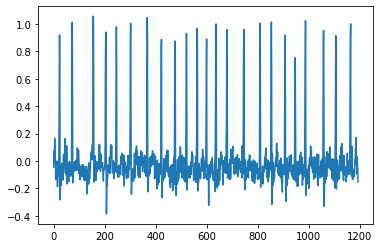

In [ ]:
plt.plot(X_val[0][:,0])

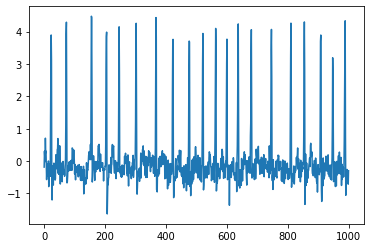

In [ ]:
plt.plot(X_te[0,:,0])

In [ ]:
model.fit(X_tr, y_train, X_te, y_val)

Finetuning...
model: fastai_xresnet1d101


epoch,train_loss,valid_loss,time
0,0.771420,#na#,00:04


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


epoch,train_loss,valid_loss,time
0,0.357962,0.296581,00:06
1,0.221781,0.263980,00:06


epoch,train_loss,valid_loss,time
0,0.165676,#na#,00:05


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


epoch,train_loss,valid_loss,time
0,0.162177,0.265332,00:07
1,0.160792,0.264052,00:07
